In [1]:
# import csv data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cvxopt import solvers
from cvxopt import matrix
from libsvm.svmutil import *
import sys


In [2]:
# parameters
digit1=5
digit2=6
C=1
gamma=0.05
# Take file path and return X and Y seperately
def read_data(filename='./dataset/train.csv'):
    dataset = pd.read_csv(filename, header=None)
    X=dataset.iloc[:,:-1]
    X=X.values
    X=X/255
    Y=dataset.iloc[:,-1]
    Y=Y.values
    return X,Y

# get subset of data relevant to digit d and return X and Y
def get_d_X_Y(X_train,Y_train, digit1,digit2):
    # return data with label = d
    d_X=[]
    d_Y=[]
    for i in range(len(Y_train)):
        if Y_train[i]==digit1:
            d_X.append(X_train[i])
            d_Y.append(1)
        elif Y_train[i]==digit2:
            d_X.append(X_train[i])
            d_Y.append(-1)
    d_X=np.array(d_X)
    d_Y=np.array(d_Y)
    return d_X,d_Y
def get_parameters(d_X,d_Y,C):
    d_Y=d_Y.astype('float')
    A=matrix(d_Y).T
    b=matrix(0.0)
    h=matrix(np.zeros((len(d_X)*2,1)))
    for i in range(len(d_X),2*len(d_X)):
        h[i,0]=C
    G=matrix(np.zeros((len(d_X)*2,len(d_X))))
    for i in range(len(d_X)):
        G[i,i]=-1
        G[i+len(d_X),i]=1
    q=matrix(-np.ones((len(d_X),1)))
    P=matrix(np.zeros((len(d_X),len(d_X))))
    for i in range(len(d_X)):
        for j in range(len(d_X)):
            P[i,j]=np.dot(d_X[i],d_X[j])
            P[i,j]*=d_Y[i]*d_Y[j]
    return P,q,G,h,A,b

# solve quadratic optimization with CVXOPT

# 1/2*xtPx+qtx
# Gx<=h
# Ax=b
def solve_cvxopt(P,q,G,h,A,b):
    sol=solvers.qp(P,q,G,h,A,b)
    return sol['x']

# get support vectors

def get_support_vectors(alpha_D,d_X,d_Y):
    scount=0
    support_vectors=[]
    support_vectors_indices=[]
    for i in range(len(alpha_D)):
        if alpha_D[i]>0.0001:
            scount+=1
            support_vectors.append(alpha_D[i])
            support_vectors_indices.append(i)
        else:
            support_vectors.append(0)
    support_vectors=np.array(support_vectors)
    print(scount)
    # save support vectors to "support_vectors_linear.txt" file
    with open("support_vectors_linear.txt", "w") as f:
        for i in range(len(support_vectors_indices)):
            f.write(str(support_vectors_indices[i])+"\n")
    return support_vectors
def get_w_b(support_vectors,X_D,Y_D):
    W=[]
    for i in range(len(support_vectors)):
        if i==0:
            W=support_vectors[i]*Y_D[i]*X_D[i]
        else:
            W+=support_vectors[i]*Y_D[i]*X_D[i]
    W=np.array(W)
    temp0=np.dot(X_D,W)
    minsofar=1e10
    maxsofar=-1e10
    for i in range(len(temp0)):
        if Y_D[i]==1:
            if temp0[i]<minsofar:
                minsofar=temp0[i]
        else:
            if temp0[i]>maxsofar:
                maxsofar=temp0[i]
    b=-(minsofar+maxsofar)/2

    return W,b
# predict on data
def predict(W,b,filename):
    X_test, Y_test = read_data(filename)
    X_D, Y_D = get_d_X_Y(X_test,Y_test, digit1,digit2)
    Y_pred=[]
    for i in range(len(X_D)):
        temp=np.dot(X_D[i],W)+b
        if temp>0:
            Y_pred.append(1)
        else:
            Y_pred.append(-1)
    Y_pred=np.array(Y_pred)
    correct=0
    for i in range(len(Y_D)):
        if Y_D[i]==Y_pred[i]:
            correct+=1
    correct=correct/len(Y_D)
    return correct,Y_pred

In [13]:
X_train, Y_train = read_data()
X_D, Y_D = get_d_X_Y(X_train,Y_train, digit1,digit2)
P,q,G,h,A,b=get_parameters(X_D,Y_D,C)
alpha_D=solve_cvxopt(P,q,G,h,A,b)
support_vectors=get_support_vectors(alpha_D,X_D,Y_D)
W,b=get_w_b(support_vectors,X_D,Y_D)


     pcost       dcost       gap    pres   dres
 0: -5.2610e+02 -8.4478e+03  5e+04  3e+00  9e-13
 1: -3.2715e+02 -4.8554e+03  9e+03  4e-01  7e-13
 2: -2.0434e+02 -1.9641e+03  3e+03  1e-01  5e-13
 3: -1.3636e+02 -1.0002e+03  2e+03  6e-02  3e-13
 4: -9.3999e+01 -5.8828e+02  9e+02  3e-02  2e-13
 5: -6.7155e+01 -3.2739e+02  4e+02  1e-02  2e-13
 6: -5.3369e+01 -1.6077e+02  2e+02  5e-03  2e-13
 7: -4.9467e+01 -7.7687e+01  4e+01  8e-04  2e-13
 8: -5.0554e+01 -5.8168e+01  8e+00  2e-16  2e-13
 9: -5.2738e+01 -5.4860e+01  2e+00  1e-15  2e-13
10: -5.3488e+01 -5.3909e+01  4e-01  1e-15  2e-13
11: -5.3665e+01 -5.3686e+01  2e-02  3e-16  2e-13
12: -5.3674e+01 -5.3675e+01  3e-04  5e-16  2e-13
13: -5.3675e+01 -5.3675e+01  3e-06  2e-15  2e-13
Optimal solution found.
233


Train data accuracy:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.39891751e-01 -8.40879378e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.

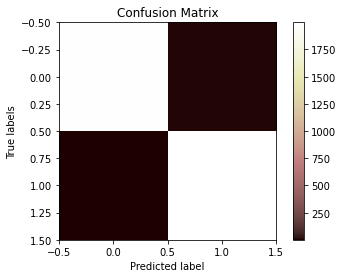

(0.9975, array([-1,  1,  1, ..., -1,  1, -1]))
Test data accuracy:
(0.9675675675675676, array([-1, -1,  1, ..., -1,  1, -1]))


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
def draw_confusion(conf):
	plt.imshow(conf)
	plt.title("Confusion Matrix")
	plt.colorbar()
	plt.set_cmap("Greens")
	plt.ylabel("True labels")
	plt.xlabel("Predicted label")
	plt.show()
print("Train data accuracy:")
print(W)
print(b)
accuracy,predictions=predict(W,b,'./dataset/train.csv')
print(accuracy)
confatrix = confusion_matrix(Y_D,predictions)
f1_matrix = f1_score(Y_D,predictions,average=None)
print("F1 Score")
print(f1_matrix)
print("Confusion Matrix")
print(confatrix)
macro_f1 = f1_score(Y_D,predictions,average='macro')
print("Macro F1 Score")
print(macro_f1)
draw_confusion(confatrix)
print(predict(W,b,"./dataset/train.csv"))
print("Test data accuracy:")
print(predict(W,b,"./dataset/test.csv"))



In [5]:
# gaussian kernel
def get_parameters_gaussian_kernel(d_X,d_Y,C,gamma):
    m=len(d_X)
    d_Y=d_Y.astype('float')
    A=matrix(d_Y).T
    b=matrix(0.0)
    h=matrix(np.zeros((len(d_X)*2,1)))
    for i in range(len(d_X),2*len(d_X)):
        h[i,0]=C
    G=matrix(np.zeros((len(d_X)*2,len(d_X))))
    for i in range(len(d_X)):
        G[i,i]=-1
        G[i+len(d_X),i]=1
    q=matrix(-np.ones((len(d_X),1)))
    kernel=np.asmatrix(np.zeros((m,m),dtype='float'))
    for i in range(m):
        for j in range(m):
            kernel[i,j]=np.exp(-gamma*np.linalg.norm(d_X[i]-d_X[j])**2)
    P=matrix(np.zeros((len(d_X),len(d_X))))
    for i in range(len(d_X)):
        for j in range(len(d_X)):
            P[i,j]=kernel[i,j]
            P[i,j]*=d_Y[i]*d_Y[j]
    return P,q,G,h,A,b
gamma=0.05
P,q,G,h,A,b=get_parameters_gaussian_kernel(X_D,Y_D,C,gamma)
alpha_D=solve_cvxopt(P,q,G,h,A,b)
support_vectors=get_support_vectors(alpha_D,X_D,Y_D)
W,b=get_w_b(support_vectors,X_D,Y_D)
    

     pcost       dcost       gap    pres   dres
 0: -1.9096e+02 -5.7730e+03  2e+04  2e+00  1e-15
 1: -1.1383e+02 -2.7535e+03  4e+03  1e-01  9e-16
 2: -1.6306e+02 -5.4871e+02  4e+02  1e-02  1e-15
 3: -2.0648e+02 -2.9981e+02  1e+02  2e-03  9e-16
 4: -2.1929e+02 -2.4903e+02  3e+01  5e-04  6e-16
 5: -2.2479e+02 -2.3257e+02  8e+00  6e-05  6e-16
 6: -2.2651e+02 -2.2819e+02  2e+00  1e-05  5e-16
 7: -2.2700e+02 -2.2713e+02  1e-01  5e-07  6e-16
 8: -2.2704e+02 -2.2705e+02  5e-03  1e-08  6e-16
 9: -2.2705e+02 -2.2705e+02  1e-04  2e-10  5e-16
Optimal solution found.
1496


Train data accuracy:
0.929
F1 Score
[0.92931807 0.92867906]
Confusion Matrix
[[1867  133]
 [ 151 1849]]
Macro F1 Score
0.928998562220885


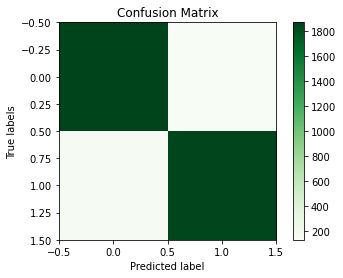

(0.929, array([-1,  1,  1, ..., -1,  1, -1]))
Test data accuracy:
(0.9324324324324325, array([-1, -1,  1, ..., -1, -1, -1]))


In [6]:
print("Train data accuracy:")
accuracy,predictions=predict(W,b,'./dataset/train.csv')
print(accuracy)
confatrix = confusion_matrix(Y_D,predictions)
f1_matrix = f1_score(Y_D,predictions,average=None)
print("F1 Score")
print(f1_matrix)
print("Confusion Matrix")
print(confatrix)
macro_f1 = f1_score(Y_D,predictions,average='macro')
print("Macro F1 Score")
print(macro_f1)
draw_confusion(confatrix)
print(predict(W,b,"./dataset/train.csv"))
print("Test data accuracy:")
print(predict(W,b,"./dataset/test.csv"))

In [7]:
# predict using libsvm
gamma=0.05
def libsvm_lib(X_D,Y_D,gamma,C):

    problem=svm_problem(Y_D,X_D)
    # linear kernel
    linear_param=svm_parameter('-s 0 -t 0 -c '+str(C))
    linear_model=svm_train(problem,linear_param)
    linear_pred_lbl,linear_pred_acc,linear_pred_vals=svm_predict(Y_D,X_D,linear_model)
    # gaussian kernel
    gaussian_param=svm_parameter('-s 0 -t 2 -g '+str(gamma)+' -c '+str(C))
    gaussian_model=svm_train(problem,gaussian_param)
    gaussian_pred_lbl,gaussian_pred_acc,gaussian_pred_vals=svm_predict(Y_D,X_D,gaussian_model)
    print("Linear Kernel")
    print("Gaussian Kernel")
    print(gaussian_pred_acc)
libsvm_lib(X_D,Y_D,gamma,C)


Accuracy = 99.9% (3996/4000) (classification)
Accuracy = 100% (4000/4000) (classification)
Linear Kernel
Gaussian Kernel
(100.0, 0.0, 1.0)


In [8]:
# main function
if __name__ == '__main__':
    train_path = sys.argv[0]
    test_path = sys.argv[1]
    part = sys.argv[2]
    subpart= sys.argv[3]
    if part == 'a':
        if subpart == '1':
            # part a.1
            X_train, Y_train = read_data(train_path)
            X_test, Y_test = read_data(test_path)

        elif subpart == '2':
            # part a.2
        elif subpart == '3':
            # part a.3
            from libsvm.svmutil import *
            
    else:
        if subpart == '1':
            # part b.1
        elif subpart == '2':
            # part b.2
        elif subpart == '3':
            # part b.3
        elif subpart == '4':
            # part b.4


IndentationError: expected an indented block (<ipython-input-8-85e89f2a3fad>, line 15)

In [ ]:
# multi-class classification
def predict_multiclass(X_D,Y_D):
    predictions=[0 for i in range(len(X_D))]
    X_train, Y_train = read_data()
    for k1 in range(10):
        for k2 in range(k1+1,10):
            digit1=k1
            digit2=k2
            X_D, Y_D = get_d_X_Y(X_train,Y_train, digit1,digit2)
            P,q,G,h,A,b=get_parameters(X_D,Y_D,C)
            alpha_D=solve_cvxopt(P,q,G,h,A,b)
            support_vectors=get_support_vectors(alpha_D,X_D,Y_D)
            W,b=get_w_b(support_vectors,X_D,Y_D)
            